<center><img src="https://perceivelab.github.io/knowledge-discovery-course/imgs/logo.jpg" width="300" height="103"></center>
<p align=center><b>Knowledge Discovery Course</b> | A.A. 2020/2021</p>
<p align=center>HOMEWORK 1 - <i>CNN: Image Classification Task</i></p>
<p align=center>Ylenia Messina</p>

In [1]:
# Import libraries & modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd 
from pathlib import Path
from PIL import Image

# Set seed for results reproducibility
random_seed = 123
torch.manual_seed(random_seed);
np.random.seed(random_seed)

# Use GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# **Dataset**: Fruits-360

In [2]:
!wget -c https://github.com/Horea94/Fruit-Images-Dataset/archive/master.tar.gz
!tar -xzf master.tar.gz
!rm master.tar.gz
!rm ./Fruit-Images-Dataset-master/readme.md

--2021-04-20 10:40:27--  https://github.com/Horea94/Fruit-Images-Dataset/archive/master.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Horea94/Fruit-Images-Dataset/tar.gz/master [following]
--2021-04-20 10:40:27--  https://codeload.github.com/Horea94/Fruit-Images-Dataset/tar.gz/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘master.tar.gz’

master.tar.gz           [             <=>    ] 703.33M  25.6MB/s    in 30s     

2021-04-20 10:40:57 (23.6 MB/s) - ‘master.tar.gz’ saved [737492642]



In [3]:
# Create new dataset with only 10 fruits
!mkdir -p fruits/train
!mkdir -p fruits/test

!cp -r "./Fruit-Images-Dataset-master/Training/Apple Red 1" "./fruits/train/Apple Red"
!cp -r ./Fruit-Images-Dataset-master/Training/Banana ./fruits/train
!cp -r ./Fruit-Images-Dataset-master/Training/Blueberry ./fruits/train
!cp -r ./Fruit-Images-Dataset-master/Training/Kiwi ./fruits/train
!cp -r ./Fruit-Images-Dataset-master/Training/Orange ./fruits/train
!cp -r ./Fruit-Images-Dataset-master/Training/Peach ./fruits/train
!cp -r ./Fruit-Images-Dataset-master/Training/Pear ./fruits/train
!cp -r ./Fruit-Images-Dataset-master/Training/Pineapple ./fruits/train
!cp -r ./Fruit-Images-Dataset-master/Training/Strawberry ./fruits/train
!cp -r ./Fruit-Images-Dataset-master/Training/Watermelon ./fruits/train

!cp -r "./Fruit-Images-Dataset-master/Test/Apple Red 1" "/content/fruits/test/Apple Red"
!cp -r ./Fruit-Images-Dataset-master/Test/Banana ./fruits/test
!cp -r ./Fruit-Images-Dataset-master/Test/Blueberry ./fruits/test
!cp -r ./Fruit-Images-Dataset-master/Test/Kiwi ./fruits/test
!cp -r ./Fruit-Images-Dataset-master/Test/Orange ./fruits/test
!cp -r ./Fruit-Images-Dataset-master/Test/Peach ./fruits/test
!cp -r ./Fruit-Images-Dataset-master/Test/Pear ./fruits/test
!cp -r ./Fruit-Images-Dataset-master/Test/Pineapple ./fruits/test
!cp -r ./Fruit-Images-Dataset-master/Test/Strawberry ./fruits/test
!cp -r ./Fruit-Images-Dataset-master/Test/Watermelon ./fruits/test

# Zip "fruits" folder to download it and upload it into Github repository
!zip -rq fruits_dataset.zip fruits/

## Data preparation

In [4]:
import os
dest_dir = "./fruits"
os.listdir(dest_dir)

['test', 'train']

In [5]:
# Dictionary of the classes labels
fruits_labels = {0: 'Apple Red', 
                 1: 'Banana',
                 2: 'Blueberry',
                 3: 'Kiwi',
                 4: 'Orange', 
                 5: 'Peach',
                 6: 'Pear',
                 7: 'Pineapple', 
                 8: 'Strawberry', 
                 9: 'Watermelon'}

In [6]:
class FruitsDataset(Dataset):
  def __init__(self, dset_dir, train=True, transforms=T.Compose([])):
    split = "train" if train else "test"
    self.dset_dir = Path(dset_dir)/split
    self.transforms = transforms

    self.files = []

    folders = sorted(os.listdir(self.dset_dir))
    for folder in folders:
      class_idx = folders.index(folder)

      folder_dir = self.dset_dir/folder

      files = os.listdir(folder_dir)

      self.files += [{"file": folder_dir/x, "class": class_idx} for x in files]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    item = self.files[i]
    file = item['file']
    class_idx = torch.tensor(item['class'])

    img = Image.open(file).convert("RGB")
    img = self.transforms(img)
    return img, class_idx

In [7]:
# Compose transformations
transforms = T.Compose([
  T.RandomHorizontalFlip(0.5),
  T.RandomVerticalFlip(0.5),
  T.ToTensor(),
])

In [8]:
train_set = FruitsDataset(dest_dir, train=True, transforms=transforms)
test_set = FruitsDataset(dest_dir, train=False, transforms=transforms)

In [9]:
# Split train dataset into training and validation

num_train = len(train_set)          # original train set length
num_test = len(test_set)

train_idx = list(range(num_train))  # list of indexes on the training set
test_idx = list(range(num_test))    # list of indexes of the test set

import random
random.shuffle(train_idx)           # shuffle the training set

val_frac = 0.2                      # fraction of the train set we want to use as validation set
num_val = int(num_train * val_frac) # number of samples of the validation set
num_train = num_train - num_val     # updated number of samples of the training set

val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

val_set = Subset(train_set, val_idx)      # validation set
train_set = Subset(train_set, train_idx)  # training set

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as validation set")
print(f"{num_test} samples used as test set")

3864 samples used as train set
966  samples used as validation set
1615 samples used as test set


torch.Size([3, 100, 100])
Label: Watermelon


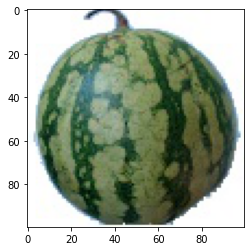

In [10]:
img, label = train_set[0]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
print('Label:', fruits_labels[label.item()])

In [11]:
# Define loaders
train_loader = DataLoader(train_set, batch_size=64, num_workers=0, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=64, num_workers=0, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=64, num_workers=0, shuffle=False)

# Train

In [12]:
# Define train function
def train(net, loaders, learning_rate, criterion, epochs=100, dev=torch.device('cpu'), save_param=False, model_name="my_model"):
    try:
        net = net.to(dev)
        performance_res = {}
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Optimizer
        optimizer = optim.SGD(net.parameters(), lr = learning_rate)

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f}")
            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              torch.save(net.state_dict(), f"{model_name}_best_val.pth")
              best_val_accuracy = epoch_accuracy["val"]
            # Save performance into a dictionary
            performance_res[epoch] = {"Epoch": int(epoch+1),
                                      "Train Loss":epoch_loss['train'],
                                      "Train Accuracy":epoch_accuracy['train'],
                                      "Val Loss":epoch_loss['val'],
                                      "Val Accuracy":epoch_accuracy['val'],
                                      "Test Loss":epoch_loss['test'],
                                      "Test Accuracy":epoch_accuracy['test']}
    except KeyboardInterrupt:
        print("Interrupted")    
    finally:
        # Plot loss & accuracy
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
  
        ax1.set_title("Loss")
        ax2.set_title("Accuracy")
        for split in ["train", "val", "test"]:
          ax1.plot(history_loss[split], label=split)
          ax1.legend()
          ax2.plot(history_accuracy[split], label=split)
          ax2.legend()
        plt.show()

    return performance_res

In [13]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

# Loss Criterion
criterion = nn.CrossEntropyLoss()

# Learning rate
learning_rate = 0.01

# Number of Epochs
num_epochs = 30

# CNNs Ablation studies

In [14]:
nets_df = pd.DataFrame(columns=["Epoch","Train Loss","Train Accuracy","Val Loss","Val Accuracy","Test Loss","Test Accuracy"])

## CNN4: Neural Network with 4 convolutional layers

In [15]:
class SimpleCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=3),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 4
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layers(x)
    return x

# Create the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(3, 3))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [16]:
img = img.unsqueeze(dim=0)
img.size()

torch.Size([1, 3, 100, 100])

In [17]:
output = model(img)
output.shape

torch.Size([1, 256, 2, 2])

In [18]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

1024


In [19]:
class CNN4(nn.Module):
  # Constructor
  def __init__(self, input_features=1024, out_classes=10):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=3),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 4
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Fully-connected layers
    self.fc_layers = nn.Sequential(
        # FC layer
        nn.Linear(in_features=input_features, out_features=512),
        nn.ReLU(),
        # Classification Layer
        nn.Linear(in_features=512, out_features=out_classes)
    )

  # Forward
  def forward(self, x):
    feature_maps = self.conv_layers(x)
    batch_size = feature_maps.size()[0]
    flatten = feature_maps.view(batch_size, -1) 
    output = self.fc_layers(flatten)
    return output

Epoch 1: TrL=2.3027, TrA=0.0919, VL=2.3021, VA=0.0938, TeL=2.3017, TeA=0.0998
Epoch 2: TrL=2.3011, TrA=0.1022, VL=2.3007, VA=0.0938, TeL=2.3000, TeA=0.0998
Epoch 3: TrL=2.2995, TrA=0.1026, VL=2.2992, VA=0.0938, TeL=2.2983, TeA=0.0998
Epoch 4: TrL=2.2977, TrA=0.1013, VL=2.2974, VA=0.0938, TeL=2.2962, TeA=0.0998
Epoch 5: TrL=2.2955, TrA=0.1022, VL=2.2952, VA=0.0938, TeL=2.2936, TeA=0.0998
Epoch 6: TrL=2.2926, TrA=0.1022, VL=2.2921, VA=0.0938, TeL=2.2902, TeA=0.0998
Epoch 7: TrL=2.2880, TrA=0.1022, VL=2.2868, VA=0.0938, TeL=2.2843, TeA=0.0998
Epoch 8: TrL=2.2803, TrA=0.1026, VL=2.2776, VA=0.0938, TeL=2.2737, TeA=0.0998
Epoch 9: TrL=2.2657, TrA=0.1013, VL=2.2589, VA=0.0938, TeL=2.2527, TeA=0.0998
Epoch 10: TrL=2.2356, TrA=0.1031, VL=2.2259, VA=0.0938, TeL=2.2135, TeA=0.0998
Epoch 11: TrL=2.1851, TrA=0.1217, VL=2.1572, VA=0.1396, TeL=2.1456, TeA=0.1214
Epoch 12: TrL=2.0637, TrA=0.1846, VL=1.9327, VA=0.2080, TeL=1.9444, TeA=0.1971
Epoch 13: TrL=1.6702, TrA=0.4257, VL=1.5779, VA=0.5417, TeL=1

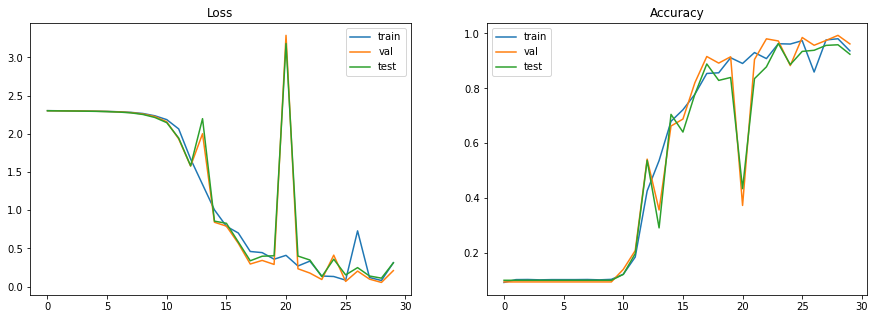

In [ ]:
# Perform train
CNN4 = CNN4()
performance_res = train(CNN4, loaders, learning_rate, criterion, epochs=num_epochs, dev=device, save_param=True, model_name="CNN4")

In [ ]:
performance_df = pd.DataFrame.from_dict(performance_res, orient="index")
best_net = performance_df.loc[[(performance_df["Val Accuracy"]).idxmax()]]
nets_df = pd.concat([nets_df, best_net], axis=0)
best_net

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy,Test Loss,Test Accuracy
28,29,0.080794,0.980789,0.055063,0.993164,0.11122,0.958814


## CNN3: Neural Network with 3 convolutional layers

In [20]:
class SimpleCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=3),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layers(x)
    return x

In [21]:
model = SimpleCNN()
output = model(img)
output.shape

torch.Size([1, 128, 6, 6])

In [22]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

4608


In [ ]:
class CNN3(nn.Module):
  # Constructor
  def __init__(self, input_features=4608, out_classes=10):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=3),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Fully-connected layers
    self.fc_layers = nn.Sequential(
        # FC layer
        nn.Linear(in_features=input_features, out_features=512),
        nn.ReLU(),
        # Classification Layer
        nn.Linear(in_features=512, out_features=out_classes)
    )

  # Forward
  def forward(self, x):
    feature_maps = self.conv_layers(x)
    batch_size = feature_maps.size()[0]
    flatten = feature_maps.view(batch_size, -1) 
    output = self.fc_layers(flatten)
    return output

Epoch 1: TrL=2.2975, TrA=0.1539, VL=2.2922, VA=0.1328, TeL=2.2924, TeA=0.1587
Epoch 2: TrL=2.2852, TrA=0.1140, VL=2.2773, VA=0.0938, TeL=2.2761, TeA=0.0998
Epoch 3: TrL=2.2569, TrA=0.1034, VL=2.2333, VA=0.0947, TeL=2.2288, TeA=0.0998
Epoch 4: TrL=2.1578, TrA=0.1487, VL=2.0379, VA=0.2865, TeL=2.0516, TeA=0.2590
Epoch 5: TrL=1.6957, TrA=0.4409, VL=1.7042, VA=0.3545, TeL=1.7016, TeA=0.3738
Epoch 6: TrL=1.2695, TrA=0.5369, VL=1.8441, VA=0.4440, TeL=1.9543, TeA=0.3870
Epoch 7: TrL=1.0663, TrA=0.6270, VL=1.1354, VA=0.5059, TeL=1.0677, TeA=0.4972
Epoch 8: TrL=0.8152, TrA=0.7023, VL=0.7642, VA=0.7327, TeL=0.6328, TeA=0.7735
Epoch 9: TrL=0.6334, TrA=0.7718, VL=0.9859, VA=0.6302, TeL=0.8597, TeA=0.6424
Epoch 10: TrL=0.5575, TrA=0.8139, VL=1.0671, VA=0.7100, TeL=0.8901, TeA=0.7416
Epoch 11: TrL=0.5164, TrA=0.8309, VL=0.3632, VA=0.8464, TeL=0.3339, TeA=0.8978
Epoch 12: TrL=0.2695, TrA=0.9123, VL=2.3744, VA=0.4772, TeL=2.3492, TeA=0.4008
Epoch 13: TrL=0.3957, TrA=0.8925, VL=0.2420, VA=0.9219, TeL=0

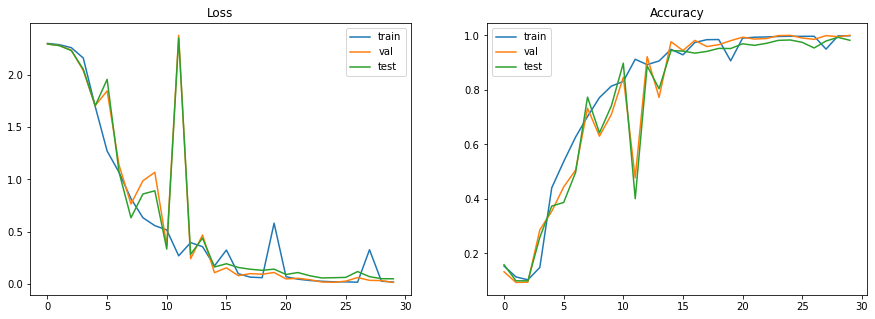

In [ ]:
# Perform train
CNN3 = CNN3()
performance_res = train(CNN3, loaders, learning_rate, criterion, epochs=num_epochs, dev=device, save_param=True, model_name="CNN3")

In [ ]:
performance_df = pd.DataFrame.from_dict(performance_res, orient="index")
best_net = performance_df.loc[[(performance_df["Val Accuracy"]).idxmax()]]
nets_df = pd.concat([nets_df, best_net], axis=0)
best_net

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy,Test Loss,Test Accuracy
24,25,0.021063,0.99667,0.016639,1.0,0.060513,0.983013


## CNN2: Neural Network with 2 convolutional layers

In [23]:
class SimpleCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=3),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layers(x)
    return x

In [24]:
model = SimpleCNN()
output = model(img)
output.shape

torch.Size([1, 64, 15, 15])

In [25]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

14400


In [ ]:
class CNN2(nn.Module):
  # Constructor
  def __init__(self, input_features=14400, out_classes=10):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=3),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Fully-connected layers
    self.fc_layers = nn.Sequential(
        # FC layer
        nn.Linear(in_features=input_features, out_features=512),
        nn.ReLU(),
        # Classification Layer
        nn.Linear(in_features=512, out_features=out_classes)
    )

  # Forward
  def forward(self, x):
    feature_maps = self.conv_layers(x)
    batch_size = feature_maps.size()[0]
    flatten = feature_maps.view(batch_size, -1) 
    output = self.fc_layers(flatten)
    return output

Epoch 1: TrL=2.1886, TrA=0.1970, VL=1.9701, VA=0.2874, TeL=1.9882, TeA=0.2590
Epoch 2: TrL=1.5132, TrA=0.4995, VL=1.6017, VA=0.5244, TeL=1.5268, TeA=0.5294
Epoch 3: TrL=1.1230, TrA=0.6134, VL=0.8731, VA=0.6842, TeL=0.9036, TeA=0.6689
Epoch 4: TrL=0.8858, TrA=0.6803, VL=0.8140, VA=0.7139, TeL=0.8925, TeA=0.6712
Epoch 5: TrL=0.7448, TrA=0.7361, VL=0.5938, VA=0.7686, TeL=0.6833, TeA=0.7332
Epoch 6: TrL=0.6065, TrA=0.7790, VL=0.9907, VA=0.6104, TeL=1.0145, TeA=0.6232
Epoch 7: TrL=0.5066, TrA=0.8263, VL=0.8297, VA=0.6826, TeL=0.7186, TeA=0.7557
Epoch 8: TrL=0.3852, TrA=0.8617, VL=0.5153, VA=0.8021, TeL=0.4386, TeA=0.8875
Epoch 9: TrL=0.3417, TrA=0.8824, VL=0.6420, VA=0.7695, TeL=0.6917, TeA=0.7427
Epoch 10: TrL=0.2244, TrA=0.9296, VL=0.3986, VA=0.8451, TeL=0.4365, TeA=0.8123
Epoch 11: TrL=0.2840, TrA=0.9101, VL=0.1384, VA=0.9717, TeL=0.1244, TeA=0.9862
Epoch 12: TrL=0.1272, TrA=0.9652, VL=0.1052, VA=0.9707, TeL=0.2316, TeA=0.8940
Epoch 13: TrL=0.0910, TrA=0.9730, VL=0.3309, VA=0.8802, TeL=0

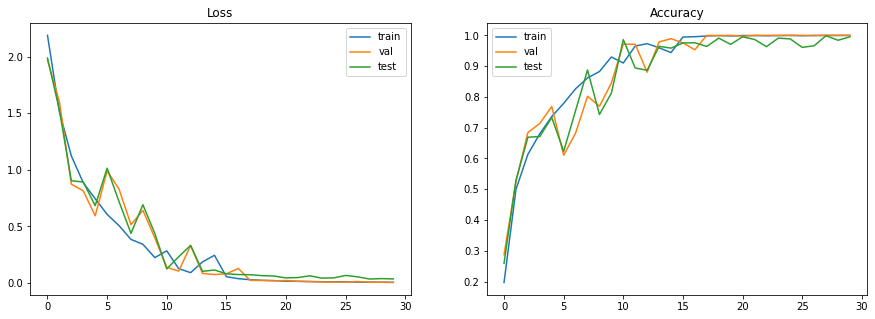

In [ ]:
# Perform train
CNN2 = CNN2()
performance_res = train(CNN2, loaders, learning_rate, criterion, epochs=num_epochs, dev=device, save_param=True, model_name="CNN2")

In [ ]:
performance_df = pd.DataFrame.from_dict(performance_res, orient="index")
best_net = performance_df.loc[[(performance_df["Val Accuracy"]).idxmax()]]
nets_df = pd.concat([nets_df, best_net], axis=0)
best_net

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy,Test Loss,Test Accuracy
17,18,0.028817,0.997951,0.023168,1.0,0.072917,0.963902


## CNN1: Neural Network with 1 convolutional layer

In [26]:
class SimpleCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [27]:
model = SimpleCNN()
output = model(img)
output.shape

torch.Size([1, 32, 16, 16])

In [28]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

8192


In [ ]:
class CNN1(nn.Module):
  # Constructor
  def __init__(self, input_features=8192, out_classes=10):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Fully-connected layers
    self.fc_layers = nn.Sequential(
        # FC layer
        nn.Linear(in_features=input_features, out_features=512),
        nn.ReLU(),
        # Classification Layer
        nn.Linear(in_features=512, out_features=out_classes)
    )

  # Forward
  def forward(self, x):
    feature_maps = self.conv_layer(x)
    batch_size = feature_maps.size()[0]
    flatten = feature_maps.view(batch_size, -1) 
    output = self.fc_layers(flatten)
    return output

Epoch 1: TrL=2.0010, TrA=0.3817, VL=1.6329, VA=0.4896, TeL=1.6605, TeA=0.4975
Epoch 2: TrL=1.2708, TrA=0.6119, VL=1.1409, VA=0.5290, TeL=1.1290, TeA=0.5595
Epoch 3: TrL=0.9142, TrA=0.6807, VL=1.0956, VA=0.5703, TeL=1.0145, TeA=0.5835
Epoch 4: TrL=0.7560, TrA=0.7327, VL=0.7049, VA=0.7298, TeL=0.7294, TeA=0.7423
Epoch 5: TrL=0.5690, TrA=0.8049, VL=0.7710, VA=0.6748, TeL=0.7275, TeA=0.6651
Epoch 6: TrL=0.4635, TrA=0.8496, VL=0.4348, VA=0.8333, TeL=0.3651, TeA=0.8774
Epoch 7: TrL=0.3928, TrA=0.8700, VL=0.3187, VA=0.9004, TeL=0.2921, TeA=0.8954
Epoch 8: TrL=0.2939, TrA=0.9088, VL=0.2718, VA=0.9219, TeL=0.2795, TeA=0.9093
Epoch 9: TrL=0.2659, TrA=0.9160, VL=0.2191, VA=0.9346, TeL=0.2041, TeA=0.9748
Epoch 10: TrL=0.2100, TrA=0.9415, VL=0.2408, VA=0.9248, TeL=0.2710, TeA=0.9140
Epoch 11: TrL=0.1840, TrA=0.9444, VL=0.1664, VA=0.9443, TeL=0.2113, TeA=0.9103
Epoch 12: TrL=0.2697, TrA=0.9329, VL=0.2045, VA=0.9219, TeL=0.3037, TeA=0.8622
Epoch 13: TrL=0.1175, TrA=0.9785, VL=0.0971, VA=0.9854, TeL=0

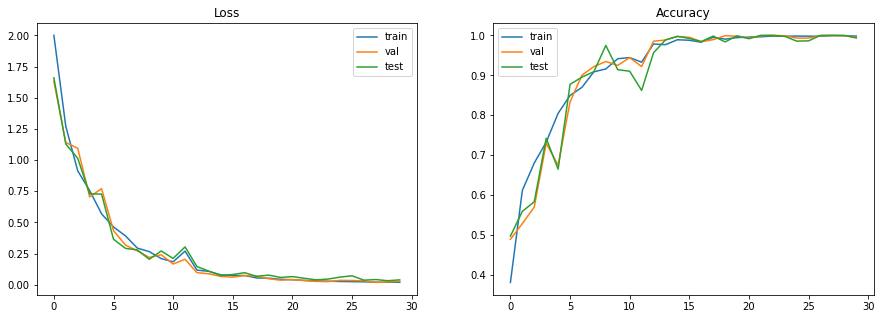

In [ ]:
# Perform train
CNN1 = CNN1()
performance_res = train(CNN1, loaders, learning_rate, criterion, epochs=num_epochs, dev=device, save_param=True, model_name="CNN1")

In [ ]:
performance_df = pd.DataFrame.from_dict(performance_res, orient="index")
best_net = performance_df.loc[[(performance_df["Val Accuracy"]).idxmax()]]
nets_df = pd.concat([nets_df, best_net], axis=0)
best_net

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy,Test Loss,Test Accuracy
22,23,0.030383,0.998207,0.027059,1.0,0.039316,1.0


# Models Evaluation

In [ ]:
nets_df['NN'] = ["CNN4", "CNN3", "CNN2", "CNN1"]
nets_df = nets_df.set_index('NN')
nets_df

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy,Test Loss,Test Accuracy
NN,,,,,,,
CNN4,29,0.080794,0.980789,0.055063,0.993164,0.111220,0.958814
CNN3,25,0.021063,0.996670,0.016639,1.000000,0.060513,0.983013
CNN2,18,0.028817,0.997951,0.023168,1.000000,0.072917,0.963902
CNN1,23,0.030383,0.998207,0.027059,1.000000,0.039316,1.000000


## Best Model

In [ ]:
best_model = nets_df.loc[[(nets_df["Val Accuracy"]).idxmax()]]
best_model

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy,Test Loss,Test Accuracy
NN,,,,,,,
CNN3,25,0.021063,0.99667,0.016639,1.0,0.060513,0.983013


In [ ]:
# Apply best_model to test set to obtain predictions for each sample
model_name = str(best_model.index.values[0])
best_model = CNN3
best_model.load_state_dict(torch.load(f"{model_name}_best_val.pth"))
best_model.to(device).eval()

predictions, targets = [], []
for images, labels in test_loader:
    predict = best_model(images.to(device))
    _, y  = torch.max(predict, dim=1)

    preds = y.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    for i in range(len(preds)):
        predictions.append(preds[i])
        targets.append(labels[i])

## Confusion Matrix

Text(69.0, 0.5, 'True Labels')

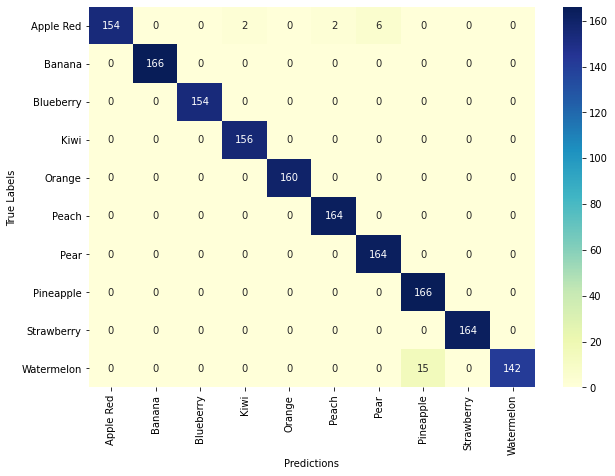

In [ ]:
cm = confusion_matrix(targets, predictions)
df_cm = pd.DataFrame(cm, fruits_labels.values(), fruits_labels.values())
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu");
plt.xlabel("Predictions")
plt.ylabel("True Labels")